## Vertically integrated u and v

In [14]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import MITgcmutils as mit
import numpy as np
from scipy import signal
import seaborn as sns
import sys
sys.path.append('/Users/Karina/Research/SVB/notebooks_SVB/')
import svb_tools as svb
import warnings
warnings.filterwarnings('ignore')

In [15]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [16]:
def unstagger(ugrid, vgrid):
    """Interpolate u and v component values to values at grid cell centres.

     :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`

    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u[..., :, :], v[..., :]

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.

    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`

    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """

    qty = (qty + qty.shift(**{index: 1})) / 2

    return qty

def plot_depth_avg_uv(nzf, times, vmin=-0.3, vmax=0.3):
    for tt in times:
        UU,VV = unstagger(dyn.variables['UVEL'][tt,:nzf,...],dyn.variables['VVEL'][tt,:nzf,...])
        ww = np.ma.masked_array(dyn.variables['WVEL'][tt,:nzf,...], mask=mask[:nzf,...])
        mask_exp = np.expand_dims(mask[:nzf,...], axis=0)
        mask_exp = mask_exp + np.zeros_like(UU)

        uu = np.ma.masked_array(UU, mask=mask[:nzf,...])
        vv = np.ma.masked_array(VV, mask=mask[:nzf,...])
        
        drF_exp = np.expand_dims(np.expand_dims(drF[:nzf], axis=1),axis=1)
        drF_exp = drF_exp + np.zeros_like(UU)

        uu_zint = (-1/Z[Zind[nzf]])*np.nansum((uu[:,:,:])*drF_exp[:nzf], axis=0)
        vv_zint = (-1/Z[Zind[nzf]])*np.nansum((vv[:,:,:])*drF_exp[:nzf], axis=0)
        ww_zint = (-1/Z[Zind[nzf]])*np.nansum((ww[:,:,:])*drF_exp[:nzf], axis=0)
 
        
        fig1, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4), sharey=True)
        ax1.set_facecolor('tan')
        ax1.set_xlabel('Lon')
        ax1.set_xlim(239-360, 246-360)
        ax1.set_title('U')
        ax2.set_facecolor('tan')
        ax2.set_xlabel('Lon')
        ax2.set_xlim(239-360, 246-360)
        ax2.set_title('V')
        ax3.set_facecolor('tan')
        ax3.set_xlabel('Lon')
        ax3.set_xlim(239-360, 246-360)
        ax3.set_title('W')
        
        pc = ax1.pcolormesh(LON,LAT,uu_zint*1E3,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax1, label='mm s$^{-1}$')
        cn = ax1.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        pc = ax2.pcolormesh(LON,LAT,vv_zint*1E3,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax2, label='mm s$^{-1}$')
        cn = ax2.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        pc = ax3.pcolormesh(LON,LAT,ww_zint*1E5,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax3, label='10$^{-2}$ mm s$^{-1}$')
        cn = ax3.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        ax1.set_ylabel('Lat')
        ax1.set_ylim(27,35.3)

        fig1.suptitle('Vertically integrated velocity components above z=%1.1f, at t=%1.1f hr' %(Z[Zind[nzf]],
                                                                                                time[tt]/3600))
        plt.show()

def plot_depth_anom_uv(nzf,nzl,times, vmin=-0.3, vmax=0.3):
    for tt in times:
        UU,VV = unstagger(dyn.variables['UVEL'][tt,:nzf,...],dyn.variables['VVEL'][tt,:nzf,...])
        ww = np.ma.masked_array(dyn.variables['WVEL'][tt,:nzf,...], mask=mask[:nzf,...])
        mask_exp = np.expand_dims(mask[:nzf,...], axis=0)
        mask_exp = mask_exp + np.zeros_like(UU)

        uu = np.ma.masked_array(UU, mask=mask[:nzf,...])
        vv = np.ma.masked_array(VV, mask=mask[:nzf,...])
        
        drF_exp = np.expand_dims(np.expand_dims(drF[:nzf], axis=1),axis=1)
        drF_exp = drF_exp + np.zeros_like(UU)

        uu_zint = (-1/Z[Zind[nzf]])*np.nansum((uu[:,:,:])*drF_exp[:nzf], axis=0)
        vv_zint = (-1/Z[Zind[nzf]])*np.nansum((vv[:,:,:])*drF_exp[:nzf], axis=0)
        ww_zint = (-1/Z[Zind[nzf]])*np.nansum((ww[:,:,:])*drF_exp[:nzf], axis=0)
 
        
        fig1, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(14,8), sharey=True, sharex=True)
        ax1.set_facecolor('tan')
        ax4.set_xlabel('Lon')
        ax1.set_xlim(239-360, 246-360)
        ax1.set_title('U anom')
        ax4.set_title('U int')
        ax2.set_facecolor('tan')
        ax5.set_xlabel('Lon')
        ax2.set_xlim(239-360, 246-360)
        ax2.set_title('V anom')
        ax5.set_title('V int ')
        ax3.set_title('W anom')
        ax6.set_title('W int')
        ax4.set_facecolor('tan')
        ax5.set_facecolor('tan')
        ax3.set_facecolor('tan')
        ax6.set_facecolor('tan')
        
        pc = ax1.pcolormesh(LON,LAT,(uu[nzl,:,:]-uu_zint)*1E3,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax1, label='mm s$^{-1}$')
        cn = ax1.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        pc = ax2.pcolormesh(LON,LAT,(vv[nzl,:,:]-vv_zint)*1E3,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax2, label='mm s$^{-1}$')
        cn = ax2.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        pc = ax3.pcolormesh(LON,LAT,(ww[nzl,:,:]-ww_zint)*1E5,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax3, label='10$^{-2}$ mm s$^{-1}$')
        cn = ax3.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])
 
        pc = ax4.pcolormesh(LON,LAT,(uu_zint)*1E3,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax4, label='mm s$^{-1}$')
        cn = ax4.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        pc = ax5.pcolormesh(LON,LAT,(vv_zint)*1E3,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax5, label='mm s$^{-1}$')
        cn = ax5.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        pc = ax6.pcolormesh(LON,LAT,ww_zint*1E5,
                           cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
        plt.colorbar(pc, ax=ax6, label='10$^{-2}$ mm s$^{-1}$')
        cn = ax6.contour(LON,LAT,depth, colors=['0','0.5'], levels=[0,250])

        ax1.set_ylabel('Lat')
        ax4.set_ylabel('Lat')
        ax1.set_ylim(27,35.3)

        fig1.suptitle('Velocity components (deviation from vert. avg. above z=%1.1f) at t=%1.1f hr' %(Z[Zind[nzf]],
                                                                                                time[tt]/3600))
        plt.show()


### February reference T and S (horizontally homogeneous density)

In [17]:
outdir = '/Volumes/KYUUBI/SVB/05_448x512x100/04_feb_TSref/mnc_test_0001/'

In [18]:
bat = mit.mnc.mnc_files(outdir+'grid.t*.nc', layout='exch2')
depth = bat.variables['Depth'][:]
lat = bat.variables['Y'][:]
lon = bat.variables['X'][:]
LAT = bat.variables['YC'][:]
LON = bat.variables['XC'][:]-360
Z = bat.variables['Z'][:]
Zl = bat.variables['Zl'][:]
drF = bat.variables['drF'][:]

# Cell-centers mask
hFacC = bat.variables['HFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
bat.close()

# Dynamics
dyn = mit.mnc.mnc_files(outdir+'dynVars.0000000000.t*.nc', layout='exch2')
Zind = (dyn.variables['diag_levels'][:]).astype(int)
time = dyn.variables['T'][:]
dyn.close()

### Domain 
* Dark grey contour: 250 m (shelf break)
* Light gray: 500 m

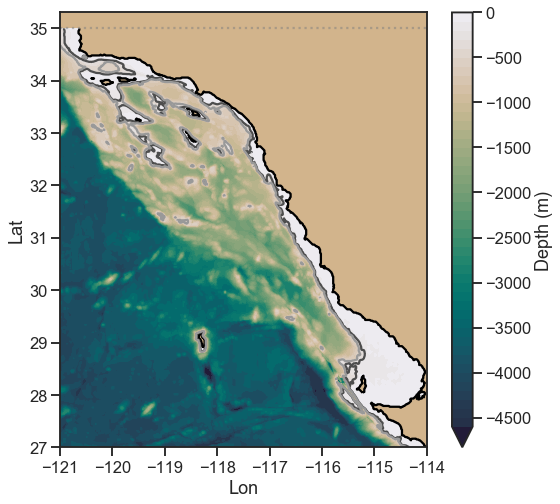

In [19]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(9,8))
ax.set_facecolor('tan')
pc = ax.contourf(LON,LAT,np.ma.masked_array(-depth, mask=mask_dep),50,
                 vmin=-5000, vmax=0, cmap=cmo.cm.rain_r, extend='min')
cb = plt.colorbar(pc, extend='min',label='depth / m')
cn = ax.contour(LON,LAT,depth, colors=['0','0.3','0.6'], levels=[0,250,500])

#ax.plot(LON[55:170:10,370:450:10],LAT[55:170:10,370:450:10], 'o',color='0.5', alpha=0.5)

ax.axhline(35, linestyle=':', color='0.5', alpha=0.5)
cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(239-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

In [20]:
dyn = mit.mnc.mnc_files(outdir+'dynVars.0000000000.t*.nc', layout='exch2')

#### Vertically integrated u and v
Top 10 m

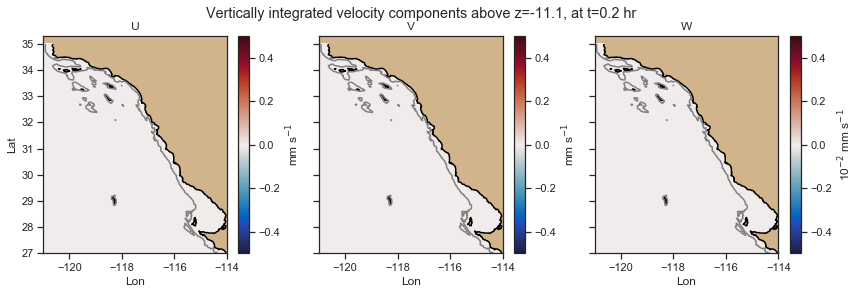

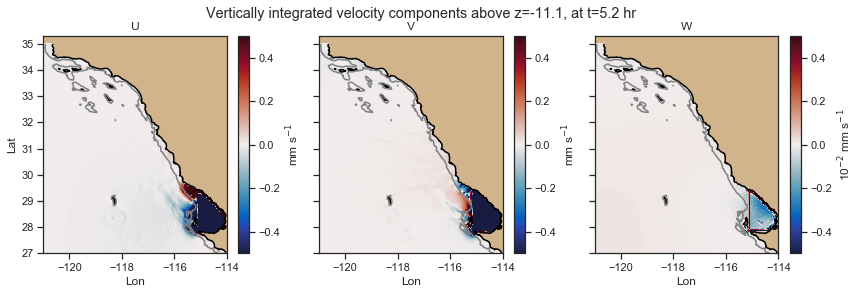

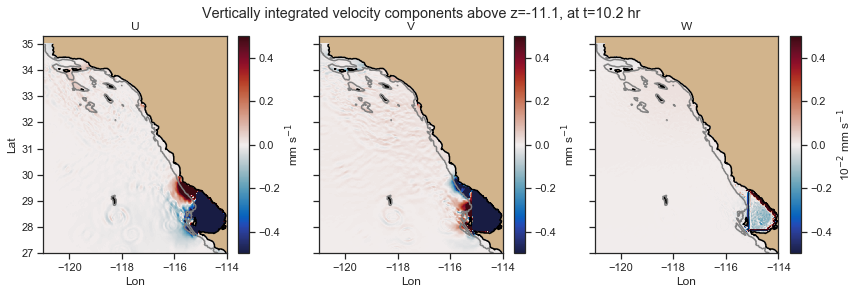

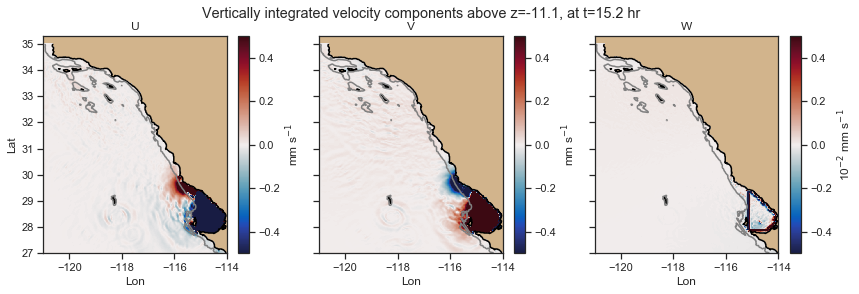

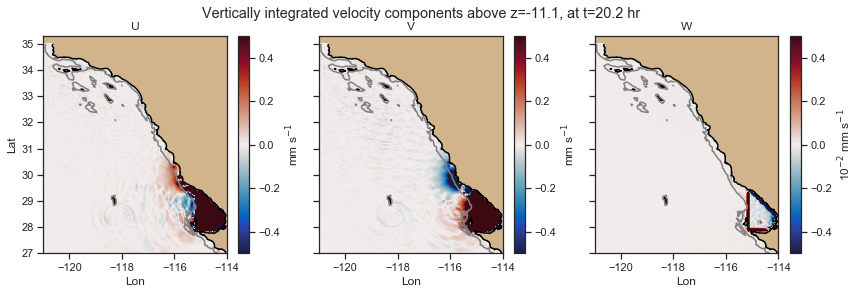

In [21]:
sns.set_context('notebook')
nzf = 4
plot_depth_avg_uv(nzf, range(0,142,30), vmin=-0.5, vmax=0.5)

Average above 250 m (shelf-break depth)

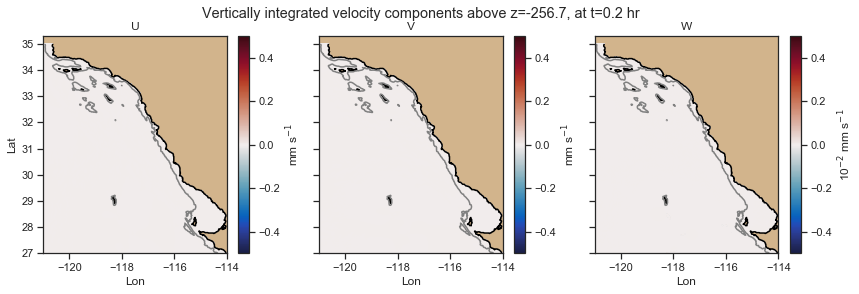

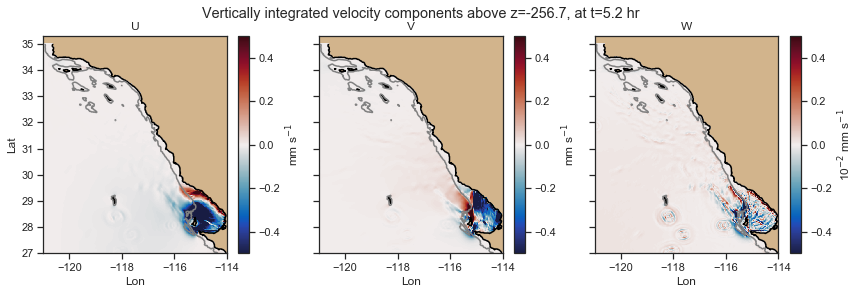

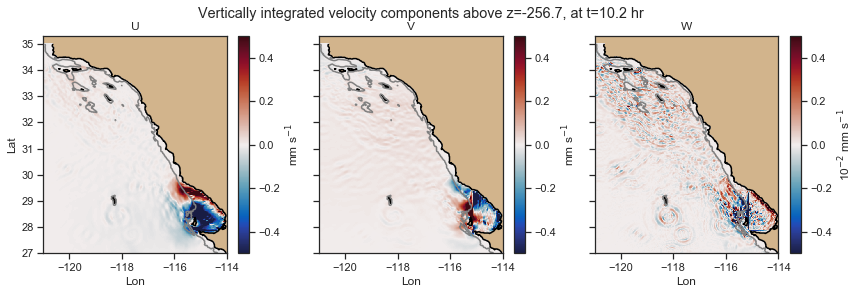

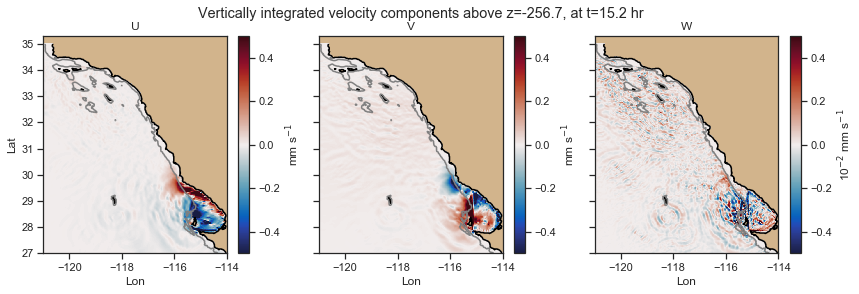

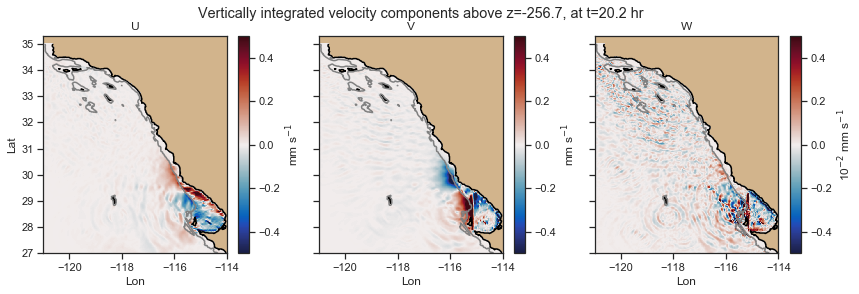

In [22]:
sns.set_context('notebook')
nzf = 42
plot_depth_avg_uv(nzf, range(0,142,30), vmin=-0.5, vmax=0.5)

top 500 m

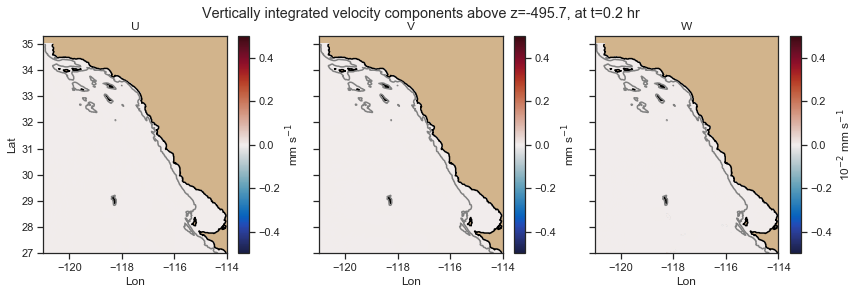

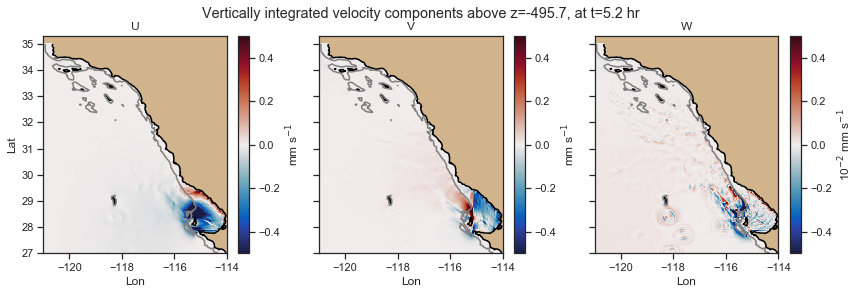

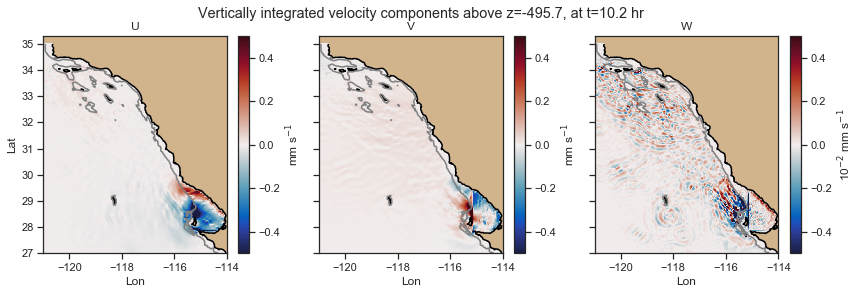

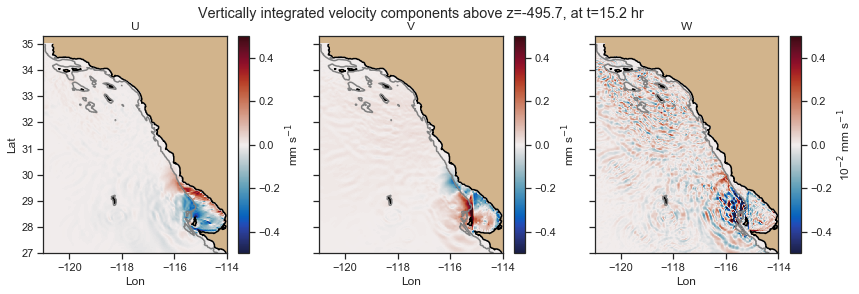

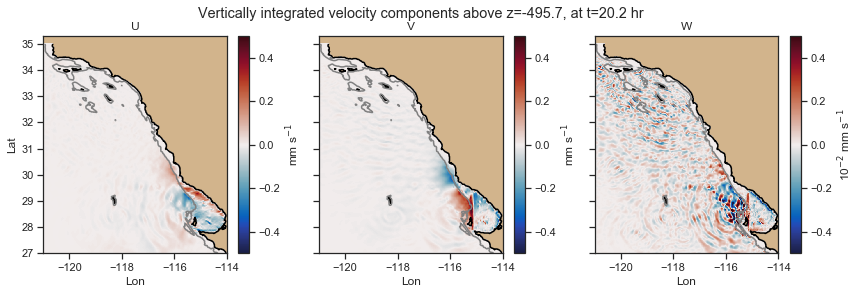

In [23]:
sns.set_context('notebook')
nzf = 54
plot_depth_avg_uv(nzf, range(0,142,30), vmin=-0.5, vmax=0.5)

top 1000 m

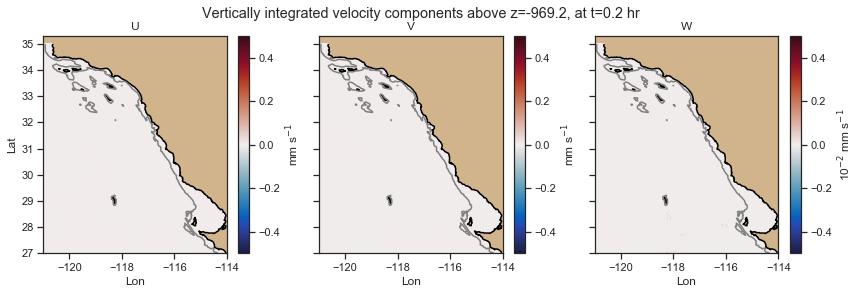

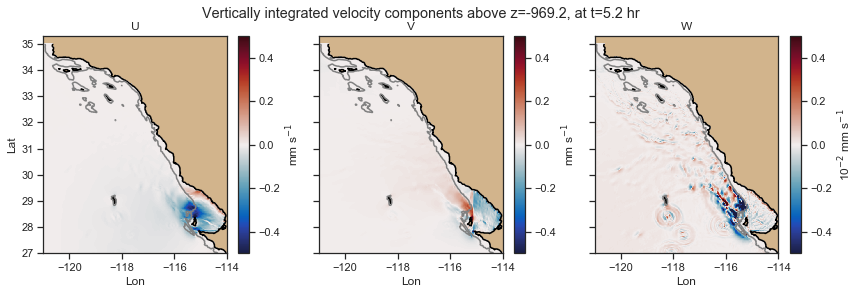

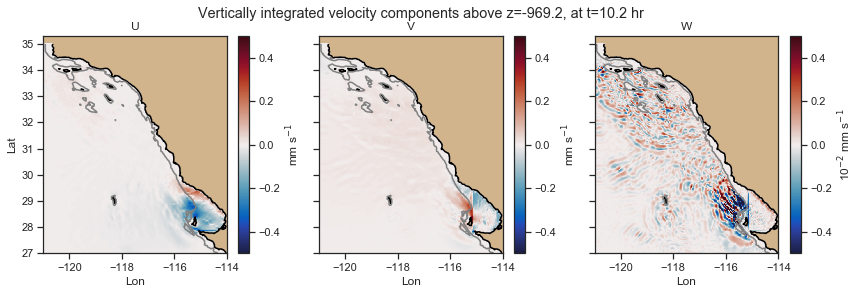

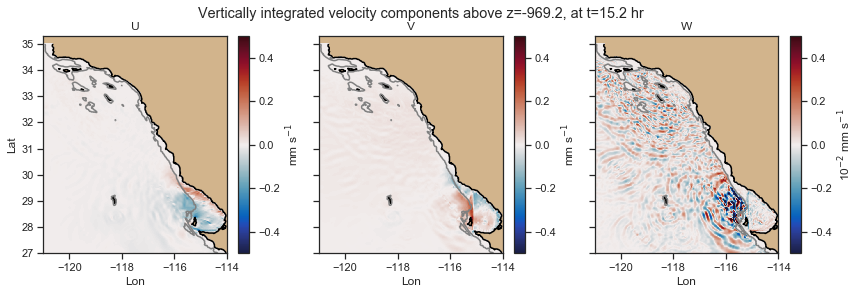

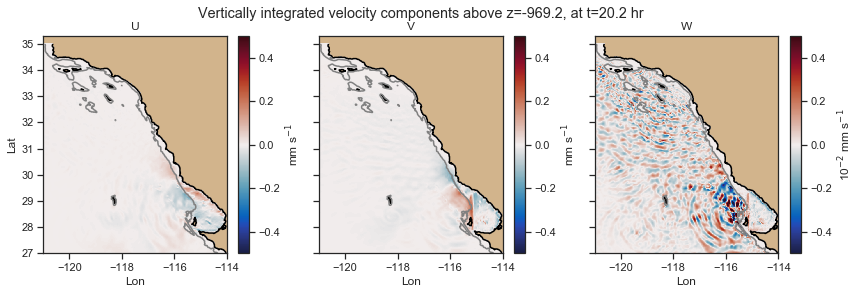

In [24]:
sns.set_context('notebook')
nzf = 69
plot_depth_avg_uv(nzf, range(0,142,30), vmin=-0.5, vmax=0.5)

#### Velocity components at different levels minus vertically averaged components

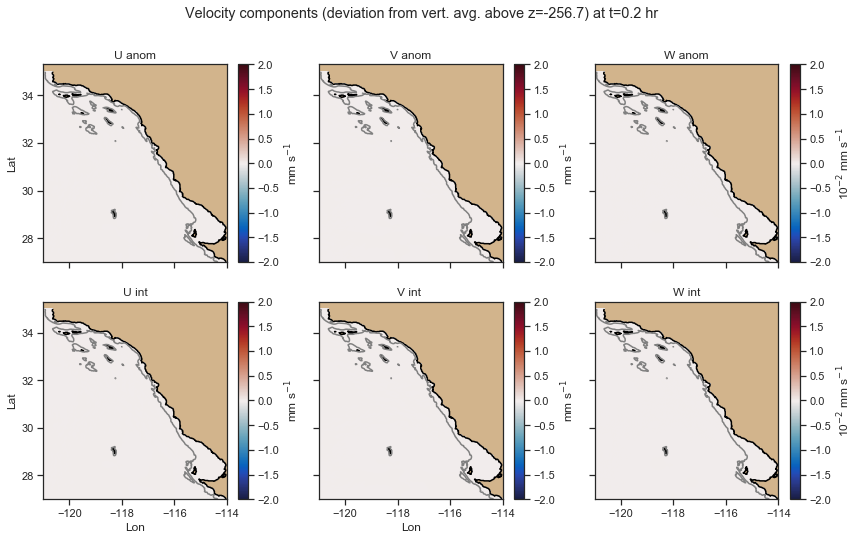

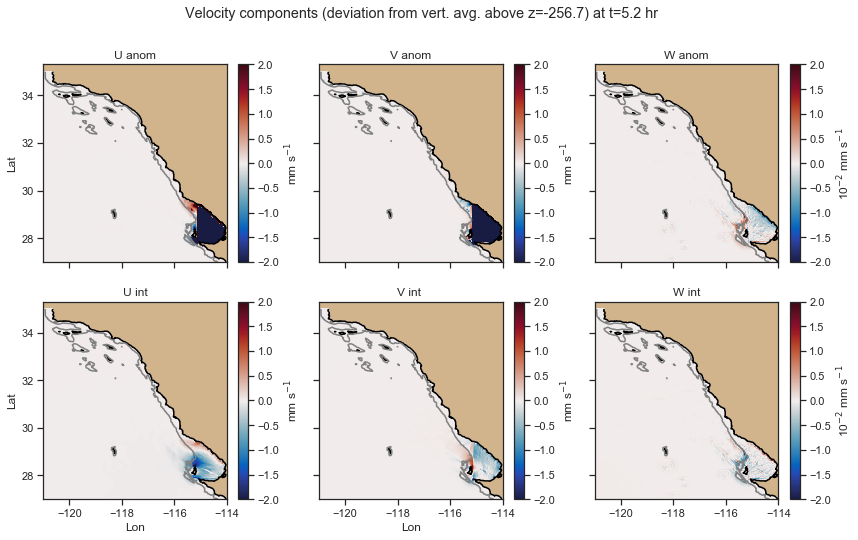

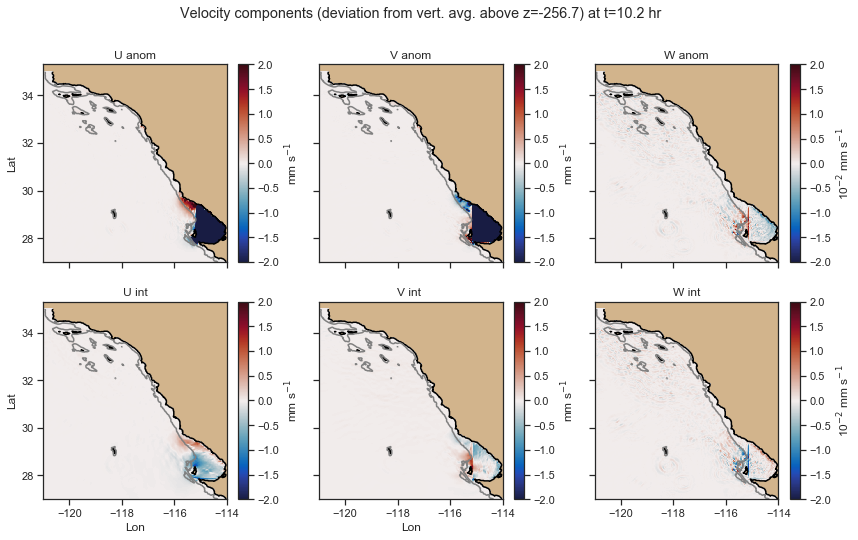

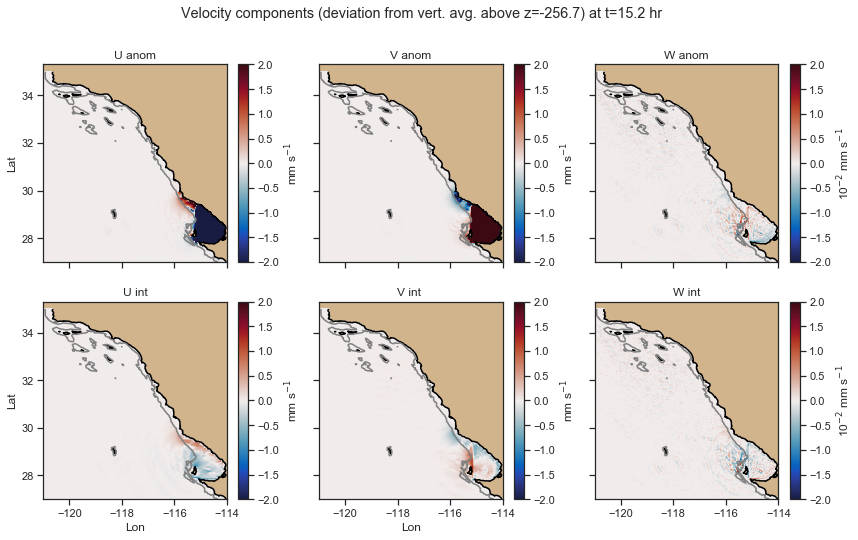

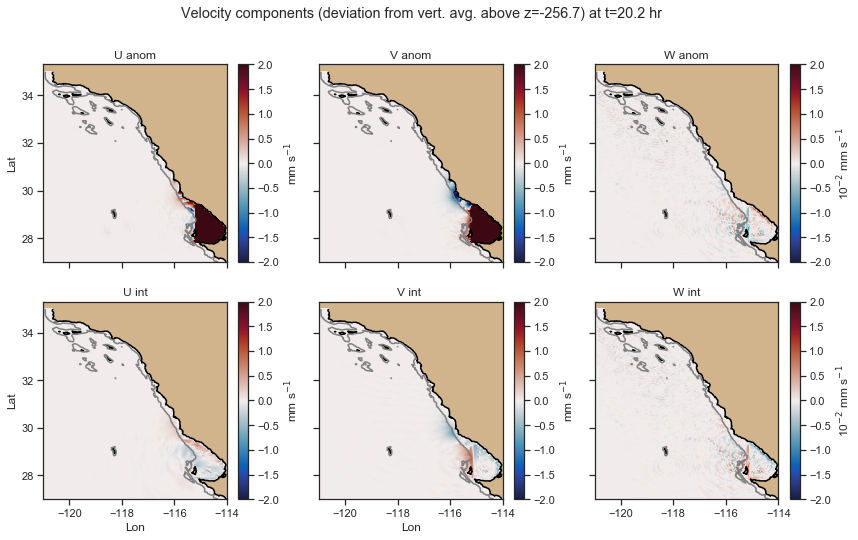

In [25]:
sns.set_context('notebook')
nzf = 42
nzl = 0
plot_depth_anom_uv(nzf, nzl, range(0,142,30),vmin=-2, vmax=2)

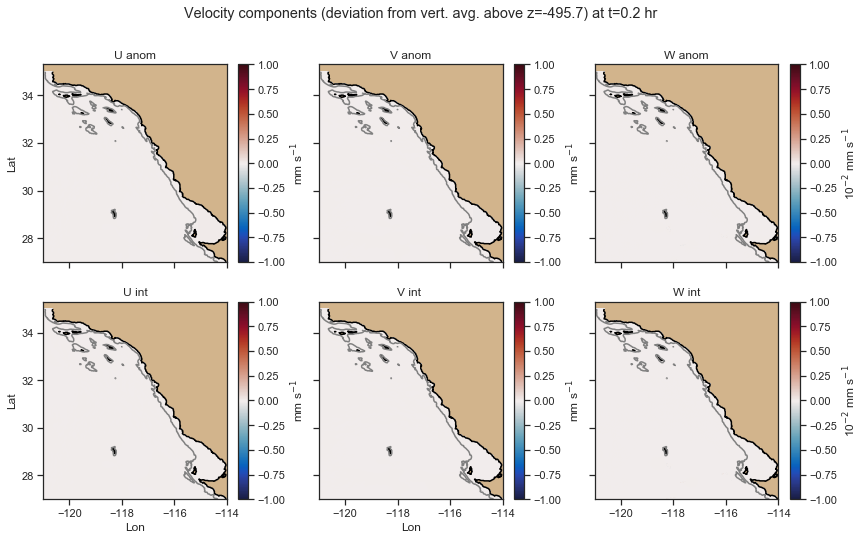

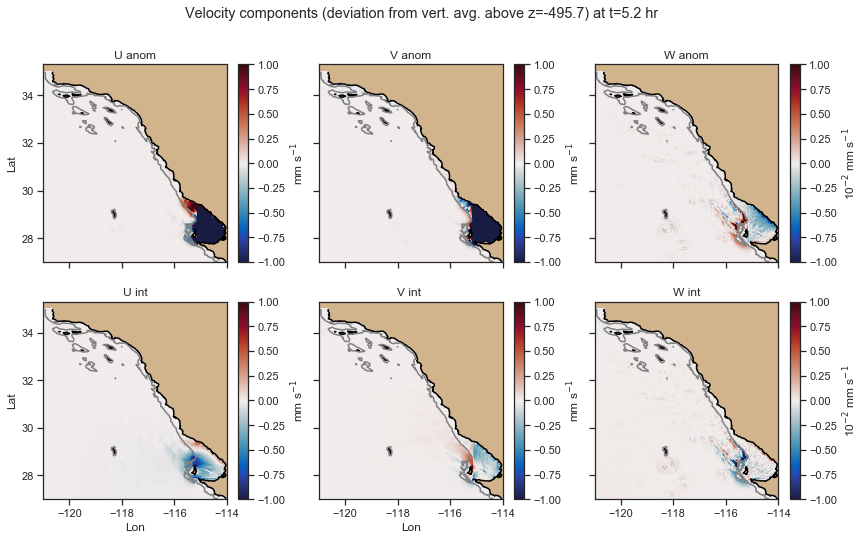

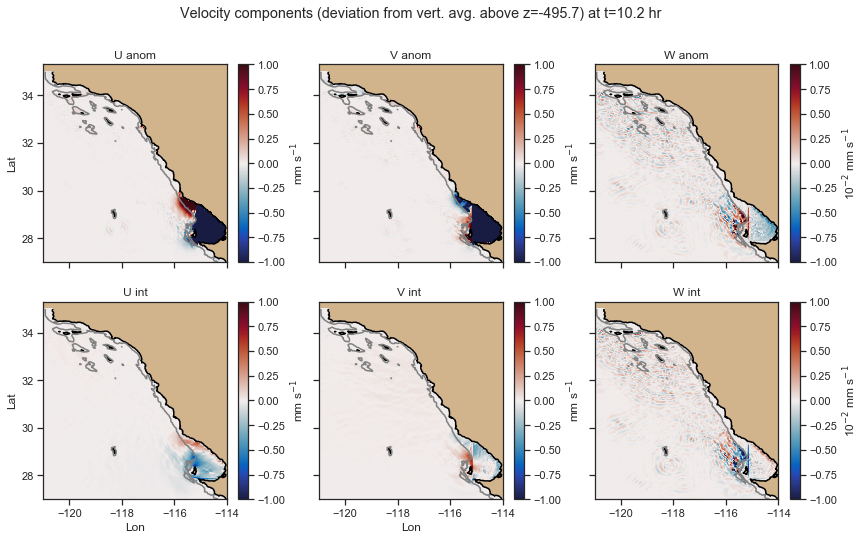

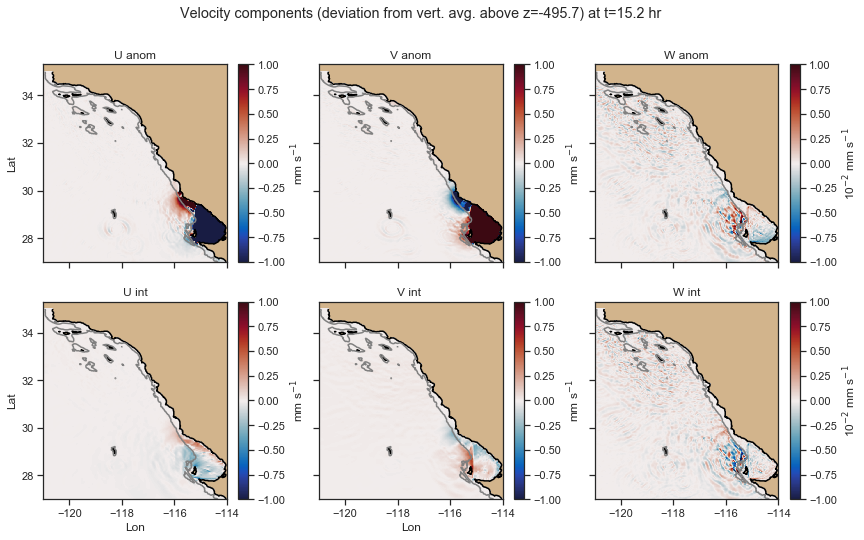

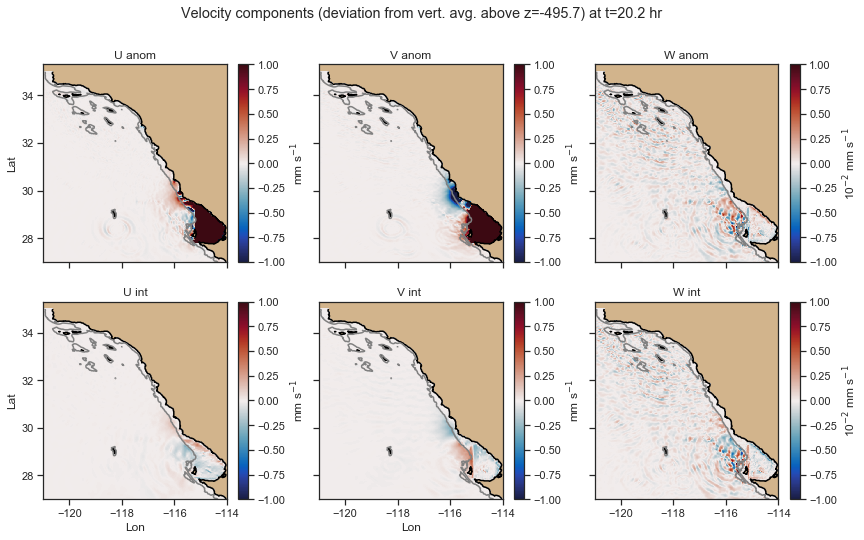

In [26]:
sns.set_context('notebook')
nzf = 54
nzl = 0
plot_depth_anom_uv(nzf, nzl, range(0,142,30),vmin=-1, vmax=1)